# Insight Plotting

### Collecting the data in the logs into a dataframe and the plotting any of the useful insights

### Imports and Defines

In [16]:
#Importing the regular expression library
import re
import pandas as pd
import datetime as dt

import numpy as np
import dateutil as dtu
import rpy2.rinterface

In [17]:
#Defining the reguar expression which describes the formatting in the logs
timeform = re.compile(r'^\d{2}:\d{2}')
jobform = re.compile(r'\(\S*\)')
logform = re.compile(r'^\d{2}:\d{2}(\s.*)\(')
dayform = re.compile(r'--\w*--')
dateform = re.compile(r'\d{2}-\d{2}-\d{2}')
lineform = re.compile(r'\n')
#defining a test string 




### String Slicing function

In [18]:
def ordExtract(string):
    if timeform.match(string):
        time = dt.datetime.strptime(timeform.findall(string)[0],'%H:%M').time()
    else:
        time = []
    jn = jobform.findall(string)
    log = logform.findall(string)
    return time, log, jn

### Extracting the data from the logfile Pythonic

In [5]:
filepath = 'C:\\Users\\j_osborne\\Documents\\JDO-Logs\\25-02-19.txt'
loglist = []
with open(filepath) as f:
    weekbegin = dt.datetime.strptime(dateform.findall(filepath)[0], '%d-%m-%y')
    x = f.read()
    for i in range(len(dayform.split(x))):   
        date = weekbegin + dt.timedelta(i-1)
        for j in lineform.split(dayform.split(x)[i]):
            time, log, jn = ordExtract(j)
            if type(time) != list:
                timestamp = dt.datetime.combine(date,time)
                record = [timestamp, log[0], jn[0]]
                loglist.append(record)
                
Logfile = pd.DataFrame(loglist, columns = ["Timestamp","Log", "JobNumber"])    
    

Small issue with the interpretation of the weekdays, in that it recvord the 3rd day entry as the 3rd day of the week regardless of if there were missing days there. needs a revamp, use a dictionary to get the "daynumber" from the correct numbers. Alternative look into the reverse of the function used in the logger program to generate the days in the first place. 

In [26]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [27]:
Beginning = dt.datetime.strftime(weekbegin, "%d-%m-%y")

In [28]:
%Rpush Logfile
%Rpush Beginning 

C:\ProgramData\Anaconda3\lib\site-packages\rpy2-2.9.4-py3.7-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [29]:
%%R -o Log_Summary
library(tidyverse)
library(lubridate)
library(viridis)
Log_Summary <- Logfile %>%
mutate(Timelead = lead(Timestamp, default = Logfile[nrow(Logfile["Log"]),"Timestamp"])) %>%
mutate(Timediff = (Timelead - Timestamp)) %>%
group_by(Day = lubridate::wday(Timestamp, label = T), JobNumber) %>%
summarise(Timeseg = as.integer(sum(Timediff)),Seconds_spent = lubridate::as.duration(Timeseg)) %>%
filter(JobNumber != "(-)")

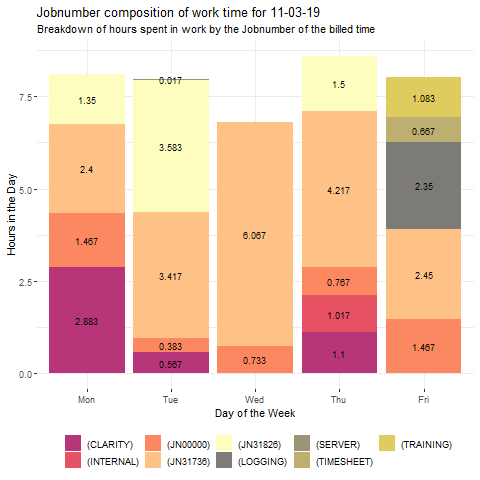

In [30]:
%%R -o Plot

Plot_Dat <- Log_Summary %>%
  rename(xBin = Day, yRate1 = Timeseg, yBin = JobNumber) %>%
  mutate(yRatemin = yRate1/3600)
PlotTit <- paste0("Jobnumber composition of work time for ",Beginning)
PlotSubTit <- "Breakdown of hours spent in work by the Jobnumber of the billed time"
xlab <-  "Day of the Week"
ylab <- "Hours in the Day"
Palette <- c(magma(5, begin = 0.5, end = 1), cividis(5, begin = 0.5, end = 1), inferno(5, begin = 0.5, end = 1))


     


Plot <- Plot_Dat %>%
  ggplot(aes(x = xBin)) +
  geom_bar(aes(fill=yBin, y =yRatemin), position=position_stack(reverse=TRUE), stat="identity") +
  geom_text(aes(label= round(yRatemin,3), y =yRatemin),
            position=position_stack(vjust=0.5),size=3) +
  scale_fill_manual(values = Palette) + 
  labs(title = PlotTit, subtitle = PlotSubTit, x = xlab, y = ylab, fill="") +
  theme_bw() +
  theme(axis.text.x=element_text(), panel.border=element_blank(), legend.position="bottom") +
  scale_y_continuous()
print(Plot)

Here I would want a section which can enumerate the utilisation of a given week, specifically the projected utilisation, that is where the number of billed hours is compared against the number of contracted hours, not the number of worked hours. Ideally this will be closer to 100% than the de facto utilisation since i'd work a bit extra

In [6]:
Logfile

,Timestamp,Log,JobNumber
0,2019-02-25 08:30:00,start,(JN00000)
1,2019-02-25 09:07:00,auditing new data prep process before big cha...,(JN31736)
2,2019-02-25 10:29:00,issues with the reminders,(JN31736)
3,2019-02-25 10:30:00,attempting to modify the system so the summar...,(JN31736)
4,2019-02-25 12:07:00,F&B catchup with hjanet,(JN30648)
5,2019-02-25 12:11:00,add in subtitle to lead into the text properly,(JN30648)
6,2019-02-25 12:23:00,add in average rates for to the summary slide...,(JN30648)
7,2019-02-25 12:24:00,Shrink multiple association and add more detai,(JN30648)
8,2019-02-25 12:24:00,remove unique assoc,(JN30648)
9,2019-02-25 12:24:00,remove size of org entiirely,(JN30648)
